## Загрузим необходимые библиотеки

In [21]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Загрузим вспомогательные функции

In [23]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [24]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Загрузим данные

In [25]:
TRAIN_DATASET_PATH = 'C:/Users/PosadskovEvS/Desktop/Рабочая СД/Матрица компетенций/DS/Kaggle/Класификация твитов/train.csv'
TEST_DATASET_PATH = 'C:/Users/PosadskovEvS/Desktop/Рабочая СД/Матрица компетенций/DS/Kaggle/Класификация твитов/test.csv'

In [26]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [27]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [28]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [29]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Разобьем выборку на тестовую и трейновую

In [36]:
test_id = pd.DataFrame(test_df['id'])

In [37]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, stratify=y)

In [39]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

In [40]:
#соберем наш простой pipeline, но нам понадобится  написать класс для выбора нужного поля
pipeline = Pipeline([('title_selector', FeatureSelector(column='text')), 
                     ('title_tfidf', TfidfVectorizer(stop_words='english', max_features=1000)), 
                     ('clf', LogisticRegression())
                    ], verbose=True)

In [41]:
pipeline.fit(X_train, y_train)

[Pipeline] .... (step 1 of 3) Processing title_selector, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing title_tfidf, total=   0.5s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.2s


Pipeline(steps=[('title_selector', FeatureSelector(column='text')),
                ('title_tfidf',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('clf', LogisticRegression())],
         verbose=True)

In [42]:
pipeline.classes_ 

array([0, 1], dtype=int64)

In [43]:
pipeline[1].transform(X_test.text)

<1904x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 9167 stored elements in Compressed Sparse Row format>

In [44]:
preds_ = pipeline.predict_proba(X_test)
preds_

array([[0.41849074, 0.58150926],
       [0.66303642, 0.33696358],
       [0.90967181, 0.09032819],
       ...,
       [0.85772854, 0.14227146],
       [0.84455865, 0.15544135],
       [0.29864539, 0.70135461]])

In [45]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.58150926, 0.33696358, 0.09032819, 0.37399042, 0.17535268,
       0.31358405, 0.83884091, 0.330647  , 0.22170313, 0.22997486])

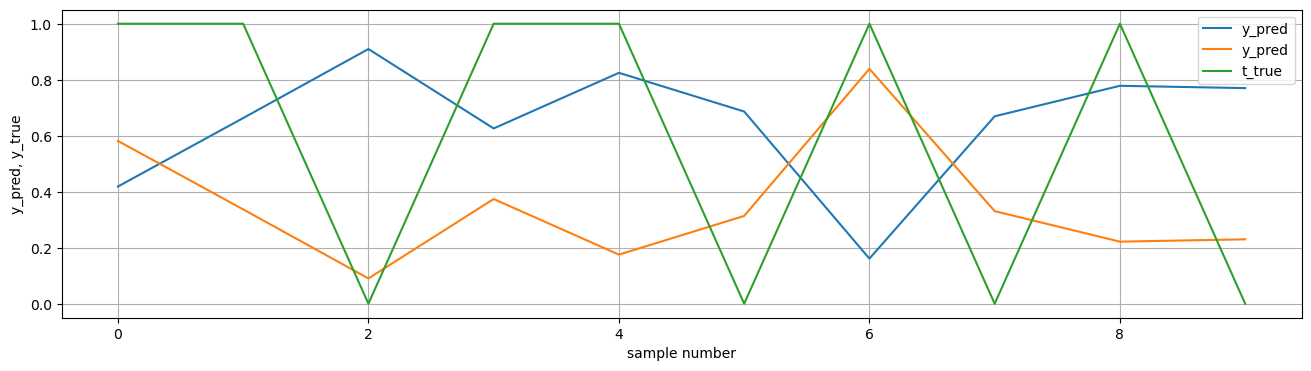

In [48]:
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('sample number')
plt.ylabel('y_pred, y_true')

plt.plot(preds_[:10], label='y_pred')
plt.plot(y_test.values[0:10], label='t_true')
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix 

In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [62]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.413307, F-Score=0.753, Precision=0.740, Recall=0.768


## Попробуем собрать pipelibe с RF

In [52]:
#соберем наш простой pipeline, но нам понадобится  написать класс для выбора нужного поля
pipeline_rf = Pipeline([('title_selector', FeatureSelector(column='text')), 
                     ('title_tfidf', TfidfVectorizer(stop_words='english', max_features=1000)), 
                     ('clf', RandomForestClassifier())
                    ], verbose=True)

In [53]:
pipeline_rf.fit(X_train, y_train)

[Pipeline] .... (step 1 of 3) Processing title_selector, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing title_tfidf, total=   0.4s
[Pipeline] ............... (step 3 of 3) Processing clf, total=  24.1s


Pipeline(steps=[('title_selector', FeatureSelector(column='text')),
                ('title_tfidf',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [54]:
pipeline_rf[1].transform(X_test.text)

<1904x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 9167 stored elements in Compressed Sparse Row format>

In [55]:
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)

In [57]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.364840, F-Score=0.730, Precision=0.713, Recall=0.747


In [59]:
ix

624

Confusion matrix, without normalization
[[865 221]
 [191 627]]


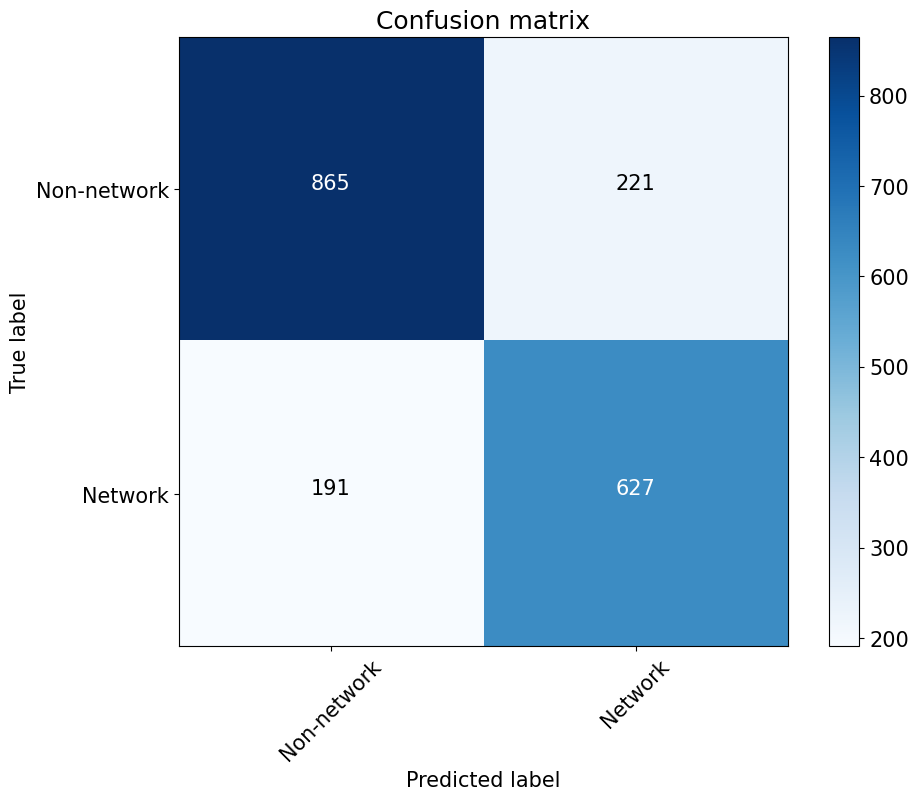

In [63]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-network', 'Network'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Обучим наш пайплайн на всей тренировочной выборке

In [22]:
pipeline_final = Pipeline([('title_selector', FeatureSelector(column='text')), 
                     ('title_tfidf', TfidfVectorizer(stop_words='english', max_features=1000)), 
                     ('clf', LogisticRegression())
                    ], verbose=True)

In [23]:
pipeline_final.fit(x, y)

[Pipeline] .... (step 1 of 3) Processing title_selector, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing title_tfidf, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s


Pipeline(steps=[('title_selector', FeatureSelector(column='text')),
                ('title_tfidf',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('clf', LogisticRegression())],
         verbose=True)

In [24]:
pipeline_final[1].transform(test_df.text)

<3263x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 15720 stored elements in Compressed Sparse Row format>

In [25]:
preds_final = pipeline_final.predict_proba(test_df)

In [26]:
preds_final

array([[0.29126268, 0.70873732],
       [0.42633854, 0.57366146],
       [0.41932349, 0.58067651],
       ...,
       [0.31540199, 0.68459801],
       [0.24250219, 0.75749781],
       [0.62841033, 0.37158967]])

In [27]:
test = pd.DataFrame(preds_final[:,1]).applymap(lambda x: '1' if (x>0.452118) else '0')

In [28]:
result = test_id.copy()

In [29]:
result['target'] = test

In [30]:
result

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [31]:
result.to_csv('Posadskov_twit_classification_predict_3.csv', index=False)

In [ ]:
precision_f, recall_f, thresholds_f = precision_recall_curve(y_test, preds)